In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

from petro_utils import compare_pred_results

import seaborn as sns

# Predicting Production with Machine Learning
The core of Petro.ai's machine learning pipeline are multivariate models that predict production based on geologic and engineering features of wells from a region of interest.  This notebook walks through a simplified workflow for building one of these models.  Your task is to run the simplified model, and understand the steps and the generated results.  You can use this as a start to improve the model, and demonstrate your experience and data science skills.

If need any clarification or have questions, feel free to reach out to Brendon at <brendon.hall@petro.ai>.

## Data
Petro.ai provides a download of well stats.  These are properties and attributes of the wells in the database.  These can be used as features to train predictive models. Well Stats contains one row per well with 100+ columns.  Don't worry, we won't use them all!

Here is a brief description of some of the columns in well stats that we might consider for modeling.
 * `totalDrainage` - predicted drainage area for a well (using Petro.ai drainage model)
 * `prodOil12mo` - cumulative 12 month oil production
 * `avgHzDistAnyZone` - average distance to nearby wells
 * `latitude`, `longitude` - surface location of well head
 * `angleFromSHMax` - angle between well azimuth and maximum horizontal stress direction


Well stats contains a raw download of all the wells in the collection.  There might be missing data, and we can transform these features before training a model.

As a first step, let's read the file `data/part2/well_stats_delaware.csv` into a pandas dataframe.

In [3]:
# read the well stats data, save to a pandas dataframe
df = pd.read_csv('../data/part2/well_stats.csv') # answer

# print the number of rows and columns in this dataframe.
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the raw well stats file.")

There are 2457 rows and 172 columns in the raw well stats file.


Let's rename the `totalDrainage` column to `drainage_area` to be more clear.

In [4]:
# rename the 'totalDrainage' column to 'drainage_area'
df.rename(columns={'totalDrainage':'drainage_area'}, inplace=True)

In [5]:
df.columns

Index(['wellID', 'wellAPI', 'interval', 'lateralLength', 'perfLength',
       'completionYear', 'totalProppant', 'totalFluidPumped', 'orientation',
       'tvd',
       ...
       'attributes_NTG_WFMP_upper', 'attributes_NTG_WFMP_lower',
       'attributes_NTG_WFMPB_upper', 'attributes_NTG_WFMPB_lower',
       'attributes_PHIT_WFMPC', 'attributes_PHIT_WFMPB_upper',
       'attributes_PHIT_WFMP_upper', 'attributes_PHIT_WFMP_lower',
       'attributes_PHIT_TBSG4', 'attributes_PHIT_WFMPB_lower'],
      dtype='object', length=172)

## Data Exploration
For an initial model we'll start with a few features from well stats described above:

- drainage area
- totalProppantByPerfLength
- avgHzDistAnyZone
- latitude
- longitude
- angleFromSHMax

There are many more we can try, but this will get us started.  For the first model,
let's try and predict 12 month cumulative oil production `prodOil12mo` directly.

First, plot the distribution of these features with respect to the `prodOil12mo` target.

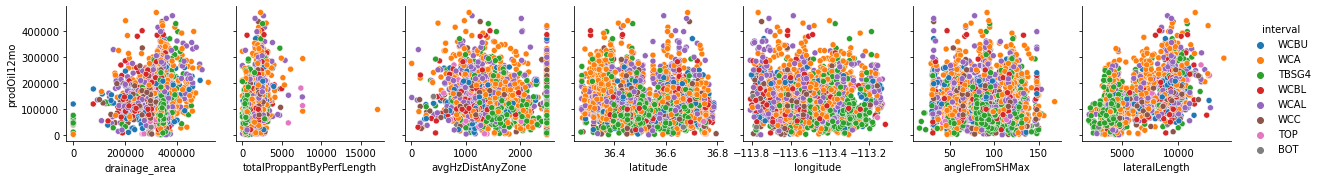

In [6]:
feature_names = ['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone', 'latitude', 'longitude', 'angleFromSHMax', 'lateralLength']

target = 'prodOil12mo'

g = sns.pairplot(df, x_vars=feature_names, y_vars=target, hue='interval')
plt.show()

Did you notice any significant trends in these features?  Any outliers or potential issues? There are a number of wells with zero drainage, we'll filter those out.

Feel free to experiment with other types of plots, features, etc.

**[Debug Question]** In the next cell, we want to find the 12 mo. cumulative oil production for a specific well with `wellAPI` = 4200000036.  There is a bug in this code though.  Can you fix it to output the correct production amount?

In [7]:
#df.head()
#print(df.shape)
#column_list = df.columns.values.tolist()
#print(column_list)
#df = df.set_index('prodOil12mo', inplace=False)

In [8]:
#well_production = df[df['wellAPI'] == "4200000036"]["prodOil12mo"].values[0]
well_production = df.query('wellAPI == 4200000036')["prodOil12mo"].item()
print("The production of the well with API 4200000036 is:", well_production)

The production of the well with API 4200000036 is: 227347.0


## Data Filtering

Remove any wells with zero drainage_area from the dataset.

In [9]:
# Remove wells with zero drainage area
df = df[df['drainage_area'] > 0].copy()

Now remove any wells that are missing data for any of the features or target from the dataset.  How many wells are left in the dataset?

In [10]:
# Remove wells missing features or production
df.dropna(subset=feature_names+[target], inplace=True)
print(f"There are {df.shape[0]} rows in the cleaned well stats file.")

There are 1798 rows in the cleaned well stats file.


## Prepare Training Data

Now the dataset is ready to train a model.  Extract the features, $X$, and the "target" to be predicted, $y$, from the dataframe.  For now, we'll randomly select a third of the wells and set them aside to test the accuracy of the model.  We'll use the remainder as training data.

In [11]:
from sklearn.model_selection import train_test_split

X = df[feature_names]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## Train Random Forest Model

Let's start simple. We'll build a simple random forest model and take a look at the prediction accuracy. 

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)



In [13]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(rf_model, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print((forest_rmse_scores))

[60535.12981701 62403.9312247  53640.72866276 53219.27402673
 63913.74458498 57819.4868625  51158.68597444 63060.14272959
 54429.69414212 48048.59512853]


## Model Evaluation
What is the $R^2$ score of this regression?  What is the error (or accuracy) of the result?

In [14]:
# mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_train, y_train_pred)
acc =  1- mean_absolute_percentage_error(y_train, y_train_pred)
print(f"Train data: the r2 score is {r2:.3f}, the accuracy is {acc:.3f}")

r2 = r2_score(y_test, y_test_pred)
acc =  1- mean_absolute_percentage_error(y_test, y_test_pred)
print(f"Test data: the r2 score is {r2:.3f}, the accuracy is {acc:.3f}")

Train data: the r2 score is 0.928, the accuracy is 0.769
Test data: the r2 score is 0.446, the accuracy is 0.164


Use the utility `compare_pred_results` function to plot the predicted vs. actual production.

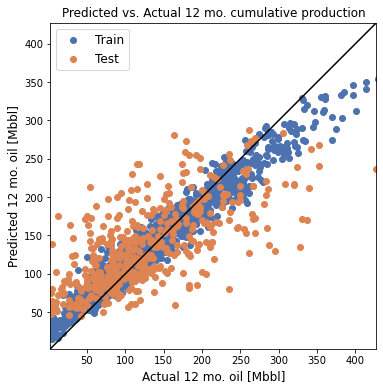

In [15]:
compare_pred_results(y_train, y_train_pred, y_test, y_test_pred, scale_factor=1e3, title="Predicted vs. Actual 12 mo. cumulative production",
                     xlabel="Actual 12 mo. oil [Mbbl]", ylabel="Predicted 12 mo. oil [Mbbl]")

The accuracy on the training data is significantly higher than the test data.  Random forest models are notorious for over-fitting. Do you notice any other interesting trends in these results?  There is plenty of room for improvement.  So far, we've guided you through building a simple model.  Now you can unleash your own skills and creativity to build a model that improves on these results.  Feel free to improve on the random forest model and/or use another library.  Be prepared to discuss your approach, what you tried, the pros/cons of your modeling approach, etc.

Some things you might try:
- hyperparameter tuning
- additional/different features from well stats
- feature selection/engineering
- proper cross-validation

You might also consider doing some error analysis.  Is the model making any big mistakes?  Is it due to bad training data or is there a systematic bias?  Can you explain why the model is making the decisions that it is?  Are some features more important than others in terms of making decisions?

Prepare a short presentation that demonstrates your data exploration, modeling and analysis efforts. Tell a story with the data. What are your insights on the problem/dataset?  Be prepared to answer questions on your approach and assumptions.  Think about how you would continue this work if you had more time and resources.  You'll give a brief presentation to a couple members of the Petro.ai team, and then we'll discussion around your experience with this task.

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 7]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
rf_model = RandomForestRegressor()
grid_search = GridSearchCV(rf_model, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 7],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009176,0.000972,0.001801,4.020564e-04,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-5.381979e+09,-3.570987e+09,...,-4.590655e+09,6.173657e+08,17,-1.205604e+09,-1.070891e+09,-1.017841e+09,-1.179030e+09,-1.309619e+09,-1.156597e+09,1.028781e+08
1,0.022550,0.000804,0.002189,4.004136e-04,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-4.394247e+09,-2.950877e+09,...,-3.656592e+09,5.267671e+08,8,-6.081937e+08,-7.256802e+08,-6.606477e+08,-5.841933e+08,-6.289163e+08,-6.415262e+08,4.899931e+07
2,0.065620,0.001169,0.004588,4.889281e-04,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.972369e+09,-2.777692e+09,...,-3.328488e+09,4.911828e+08,1,-4.769763e+08,-4.970369e+08,-5.035554e+08,-5.202484e+08,-5.078354e+08,-5.011305e+08,1.425844e+07
3,0.009973,0.000637,0.001995,8.844012e-07,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-5.505914e+09,-4.336996e+09,...,-4.634746e+09,6.313408e+08,18,-1.085318e+09,-1.170117e+09,-9.986062e+08,-1.070211e+09,-1.140361e+09,-1.092923e+09,5.946205e+07
4,0.029321,0.000489,0.002593,4.883054e-04,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-4.336340e+09,-3.285469e+09,...,-3.688515e+09,3.939075e+08,10,-5.859366e+08,-6.481139e+08,-6.805083e+08,-5.631759e+08,-6.931104e+08,-6.341690e+08,5.134640e+07


In [18]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,0.065620,0.001169,0.004588,0.000489,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.972369e+09,-2.777692e+09,...,-3.328488e+09,4.911828e+08,1,-4.769763e+08,-4.970369e+08,-5.035554e+08,-5.202484e+08,-5.078354e+08,-5.011305e+08,1.425844e+07
8,0.108110,0.001974,0.004187,0.000400,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-3.933178e+09,-2.822188e+09,...,-3.341691e+09,4.653019e+08,2,-5.153856e+08,-5.364382e+08,-4.972056e+08,-5.127026e+08,-5.177735e+08,-5.159011e+08,1.253231e+07
5,0.085771,0.001086,0.004582,0.000484,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-3.799873e+09,-2.851272e+09,...,-3.344862e+09,4.446399e+08,3,-4.931401e+08,-5.091149e+08,-5.356179e+08,-5.264075e+08,-5.192364e+08,-5.167033e+08,1.463667e+07
11,0.119480,0.002475,0.004788,0.000399,7,30,NaN,"{'max_features': 7, 'n_estimators': 30}",-4.062638e+09,-3.078810e+09,...,-3.384251e+09,4.187644e+08,4,-4.898801e+08,-5.406175e+08,-4.994638e+08,-5.184720e+08,-5.056681e+08,-5.108203e+08,1.755236e+07
13,0.026530,0.000798,0.002797,0.000390,2,10,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-4.032578e+09,-2.980892e+09,...,-3.484252e+09,3.594169e+08,5,-2.337591e-23,-2.288482e-23,-2.092046e-23,-1.952729e-23,-2.286361e-23,-2.191442e-23,1.460476e-24


In [19]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=30)

In [20]:
dt_best = grid_search.best_estimator_
print(dt_best)

RandomForestRegressor(max_features=2, n_estimators=30)
